In [5]:
import numpy as np
import pandas as pd
import sys
import os
import math
from PIL import Image 
import spacy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models
import torch.utils.data as data
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import nltk
from nltk.translate.bleu_score import corpus_bleu

In [6]:
torch.manual_seed(0)
spacy_eng = spacy.load('en_core_web_sm')

In [7]:
class Vocabulary:
    def __init__ (self, freq_threshold):
        self.itos = {0:"<PAD>", 1:"<SOS>",2: "<EOS>", 3:"<UNK>"}
        self.stoi = {"<PAD>": 0,"<SOS>":1,"<EOS>":2,"<UNK>":3}
        self.freq_threshold = freq_threshold
    def __len__(self):
        return len(self.itos)
    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]
    
    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4
        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1
                    
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)
        return [self.stoi[token] if token in self.stoi else self.stoi['<UNK>'] for token in tokenized_text]

In [8]:
class CaptionDataset(Dataset):
    def __init__(self,root_dir,captions_file,dataset_type,transform=None,freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform
        # Get img, caption columns
        self.imgs_train = self.df[self.df['train']==True]["Image_name"]
        self.captions_train = self.df[self.df['train']==True]["Paragraph"]
    
        if dataset_type == 'train':
            self.imgs = self.df[self.df['train']==True]["Image_name"].tolist()
            self.captions = self.df[self.df['train']==True]["Paragraph"].tolist()
        elif dataset_type == 'validation':
            self.imgs = self.df[self.df['val']==True]["Image_name"].tolist()
            self.captions = self.df[self.df['val']==True]["Paragraph"].tolist()
        elif dataset_type == 'test':
            self.imgs = self.df[self.df['test']==True]["Image_name"].tolist()
            self.captions = self.df[self.df['test']==True]["Paragraph"].tolist()
        
        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions_train.tolist())
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img_id = str(img_id)+'.jpg'
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img =  self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)

In [9]:
class MyCollate:
    def __init__ (self, pad_idx):
        self.pad_idx = pad_idx
        
    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)
        return imgs, targets

In [10]:
def get_loader(root_folder,annotation_file,dataset_type,transform,freq_threshold=5,batch_size=32,num_workers=2,shuffle=True,pin_memory=True,):
    dataset = CaptionDataset(root_folder, annotation_file, dataset_type,transform,freq_threshold)
    pad_idx = dataset.vocab.stoi["<PAD>"]
    loader = DataLoader(dataset=dataset,
                      batch_size=batch_size,
                      num_workers=num_workers,
                      shuffle=shuffle,
                      pin_memory=pin_memory,
                      collate_fn=MyCollate(pad_idx=pad_idx),
                      )
    return loader, dataset

In [11]:
# Encoder inputs images and returns feature maps.
class EncoderCNN(nn.Module):
    """
    Aruments:
          - image - augmented image sample
    Returns:
           - features - feature maps of size (batch, height*width, #feature maps)
    """
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        
    def forward(self, images):
        features = self.resnet(images)
        # first, we need to resize the tensor to be 
        # (batch, size*size, feature_maps)
        batch, feature_maps, size_1, size_2 = features.size()       
        features = features.permute(0, 2, 3, 1)
        features = features.view(batch, size_1*size_2, feature_maps)
       
        return features

In [12]:
# Class performs Additive Bahdanau Attention
class BahdanauAttention(nn.Module):  
    def __init__(self, num_features, hidden_dim, output_dim = 1):
        super(BahdanauAttention, self).__init__()
        self.num_features = num_features
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        # fully-connected layer to learn first weight matrix Wa
        self.W_a = nn.Linear(self.num_features, self.hidden_dim)
        # fully-connected layer to learn the second weight matrix Ua
        self.U_a = nn.Linear(self.hidden_dim, self.hidden_dim)
        # fully-connected layer to produce score (output), learning weight matrix va
        self.v_a = nn.Linear(self.hidden_dim, self.output_dim)
                
    def forward(self, features, decoder_hidden):
        """
        Arguments:
            - features - features returned from Encoder
            - decoder_hidden - hidden state output from Decoder
                
        Returns:
            - context - context vector with a size of (1,2048)
            - atten_weight - probabilities, express the feature relevance
        """
        # add additional dimension to a hidden (required for summation)
        decoder_hidden = decoder_hidden.unsqueeze(1)
        atten_1 = self.W_a(features)
        atten_2 = self.U_a(decoder_hidden)
        # apply tangent to combine result from 2 fc layers
        atten_tan = torch.tanh(atten_1+atten_2)
        atten_score = self.v_a(atten_tan)
        atten_weight = F.softmax(atten_score, dim = 1)
        # first, we will multiply each vector by its softmax score
        # next, we will sum up this vectors, producing the attention context vector
        # the size of context equals to a number of feature maps
        context = torch.sum(atten_weight * features,  dim = 1)
        atten_weight = atten_weight.squeeze(dim=2)
        
        return context, atten_weight

In [38]:
class DecoderRNN(nn.Module):

    """Attributes:
         - embedding_dim - specified size of embeddings;
         - hidden_dim - the size of RNN layer (number of hidden states)
         - vocab_size - size of vocabulary 
         - p - dropout probability
    """
    def __init__(self, num_features, embedding_dim, hidden_dim, vocab_size, p =0.5):

        super(DecoderRNN, self).__init__()
        
        self.num_features = num_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        # scale the inputs to softmax
        self.sample_temp = 0.5 
        
        # embedding layer that turns words into a vector of a specified size
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # LSTM will have a single layer of size 512 (512 hidden units)
        # it will input concatinated context vector (produced by attention) 
        # and corresponding hidden state of Decoder
        self.lstm = nn.LSTMCell(embedding_dim + num_features, hidden_dim)
        # produce the final output
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
        # add attention layer 
        self.attention = BahdanauAttention(num_features, hidden_dim)
        # dropout layer
        self.drop = nn.Dropout(p=p)
        # add initialization fully-connected layers
        # initialize hidden state and cell memory using average feature vector 
        self.init_h = nn.Linear(num_features, hidden_dim)
        self.init_c = nn.Linear(num_features, hidden_dim)

    def forward(self, captions, features, sample_prob = 0.0):
        
        # create embeddings for captions of size (batch, sqe_len, embed_dim)
        embed = self.embeddings(captions)
        h, c = self.init_hidden(features)
        seq_len = captions.size(1)
        feature_size = features.size(1)
        batch_size = features.size(0)
        # these tensors will store the outputs from lstm cell and attention weights
        outputs = torch.zeros(batch_size, seq_len, self.vocab_size).to(device)
        atten_weights = torch.zeros(batch_size, seq_len, feature_size).to(device)

        # scheduled sampling for training
        # we do not use it at the first timestep (<start> word)
        # but later we check if the probability is bigger than random
        for t in range(seq_len):
            sample_prob = 0.0 if t == 0 else 0.5
            use_sampling = np.random.random() < sample_prob
            if use_sampling == False:
                word_embed = embed[:,t,:]
            context, atten_weight = self.attention(features, h)
            # input_concat shape at time step t = (batch, embedding_dim + hidden_dim)
            input_concat = torch.cat([word_embed, context], 1)
            h, c = self.lstm(input_concat, (h,c))
            h = self.drop(h)
            output = self.fc(h)
            if use_sampling == True:
                # use sampling temperature to amplify the values before applying softmax
                scaled_output = output / self.sample_temp
                scoring = F.log_softmax(scaled_output, dim=1)
                top_idx = scoring.topk(1)[1]
                word_embed = self.embeddings(top_idx).squeeze(1) 
            outputs[:, t, :] = output
            atten_weights[:, t, :] = atten_weight
        return outputs, atten_weights

    def init_hidden(self, features):

        """Initializes hidden state and cell memory using average feature vector.
        Arguments:
            - features - features returned from Encoder
    
        Retruns:
            - h0 - initial hidden state (short-term memory)
            - c0 - initial cell state (long-term memory)
        """
        mean_annotations = torch.mean(features, dim = 1)
        h0 = self.init_h(mean_annotations)
        c0 = self.init_c(mean_annotations)
        return h0, c0
    
    def greedy_search(self, features, max_sentence = 30):

        """Greedy search to sample top candidate from distribution.
        Arguments
            - features - features returned from Encoder
            - max_sentence - max number of token per caption (default=20)
        Returns:
            - sentence - list of tokens
        """

        sentence = []
        weights = []
        input_word = torch.tensor(0).unsqueeze(0).to(device)
        h, c = self.init_hidden(features)
        while True:
            embedded_word = self.embeddings(input_word)
            context, atten_weight = self.attention(features, h)
            # input_concat shape at time step t = (batch, embedding_dim + context size)
            input_concat = torch.cat([embedded_word, context],  dim = 1)
            h, c = self.lstm(input_concat, (h,c))
            h = self.drop(h)
            output = self.fc(h)
            scoring = F.log_softmax(output, dim=1)
            top_idx = scoring[0].topk(1)[1]
            sentence.append(top_idx.item())
            weights.append(atten_weight)
            input_word = top_idx
            if (len(sentence) >= max_sentence or top_idx == 1) or top_idx.item() == '<EOS>':
                break
        return sentence, weights


In [ ]:
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

    
# Setup the transforms
transform_test = transforms.Compose([ 
    transforms.Resize((224,224)),                    # smaller edge of image resized to 256
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])


train_loader, dataset = get_loader(
        '../input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images',
        '../input/stanford-image-paragraph-captioning-dataset/stanford_df_rectified.csv',
        dataset_type='train',
        transform = transform_train,
        freq_threshold=6,batch_size=64)
    
valid_loader, dataset = get_loader(
        '../input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images',
        '../input/stanford-image-paragraph-captioning-dataset/stanford_df_rectified.csv',
        dataset_type='validation',
        transform = transform_test,
        freq_threshold=6)   

In [ ]:
embed_size = 256           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_features = 2048        # number of feature maps, produced by Encoder
vocab_size = vocab_size = len(dataset.vocab) # The size of the vocabulary.

# Initialize the encoder and decoder. 
encoder = EncoderCNN()
decoder = DecoderRNN(num_features = num_features, 
                     embedding_dim = embed_size, 
                     hidden_dim = hidden_size, 
                     vocab_size = vocab_size)

In [ ]:
# Move models to GPU if CUDA is available. 
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder.to(device)
decoder.to(device)


# Define the loss function. 
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"]).cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])


#params = list(decoder.parameters()) + list(encoder.parameters()) 
params = list(decoder.parameters())

# TODO #4: Define the optimizer.
optimizer = torch.optim.Adam(params, lr = 1e-4)

In [ ]:
min_valid_loss = np.inf
num_epochs = 50
for ep in range(num_epochs):
    train_loss = 0.0
    encoder.eval() # no fine-tuning for Encoder
    decoder.train()
    for images, captions in train_loader:
        captions = captions.transpose(0,1)
        captions_target = captions[:, 1:].to(device) 
        # captions for training without the last word
        captions_train = captions[:, :-1].to(device)
        
        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs, atten_weights = decoder(captions= captions_train,features = features)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions_target.reshape(-1)) 
        #loss = criterion(outputs.reshape(-1, outputs.shape[2]),captions.reshape(-1)) 

        loss.backward(loss)
        optimizer.step()

        train_loss += loss.item()
            
    valid_loss = 0.0
    # evaluation of encoder and decoder
    encoder.eval()
    decoder.eval()    
    for images, captions in valid_loader:
        captions = captions.transpose(0,1)
        captions_target = captions[:, 1:].to(device) 
        captions = captions[:, :-1].to(device)
        images = images.to(device)
        features = encoder(images)
        outputs, atten_weights = decoder(captions= captions,features = features)
        loss = criterion(outputs.view(-1, vocab_size),captions_target.reshape(-1))
        valid_loss += loss.item()
            
    avg_train_loss = train_loss / len(train_loader)
    avg_valid_loss = valid_loss / len(valid_loader)
    print(f'Epoch {ep+1} \t\t Training Loss: {avg_train_loss} \t\t Validation Loss: {avg_valid_loss}')
    if min_valid_loss > avg_valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f} to {avg_valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = avg_valid_loss
        # Saving State Dict
        torch.save(encoder.state_dict(), '/kaggle/working/encoder_attention_model.pth')
        torch.save(decoder.state_dict(), '/kaggle/working/decoder_attention_model.pth')
    

**INFERENCE**

In [26]:
transform_test = transforms.Compose([ 
    transforms.Resize((224,224)),                    # smaller edge of image resized to 256
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])


test_loader, dataset = get_loader(
        '../input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images',
        '../input/stanford-image-paragraph-captioning-dataset/stanford_df_rectified.csv',
        dataset_type='test',
        transform = transform_test,
        freq_threshold=6)

In [15]:
df = pd.read_csv('../input/stanford-image-paragraph-captioning-dataset/stanford_df_rectified.csv')
df

,Image_name,Paragraph,train,test,url,val
0,2356347,A large building with bars on the windows in f...,False,True,https://cs.stanford.edu/people/rak248/VG_100K/...,False
1,2317429,A white round plate is on a table with a plast...,True,False,https://cs.stanford.edu/people/rak248/VG_100K/...,False
2,2414610,A woman in a blue tennis outfit stands on a gr...,False,True,https://cs.stanford.edu/people/rak248/VG_100K_...,False
3,2365091,A large red and white train is traveling on tr...,True,False,https://cs.stanford.edu/people/rak248/VG_100K/...,False
4,2383120,A very clean and tidy a bathroom. Everything i...,True,False,https://cs.stanford.edu/people/rak248/VG_100K_...,False
...,...,...,...,...,...,...
19556,2347112,This is a picture of flowers. The flowers are ...,True,False,https://cs.stanford.edu/people/rak248/VG_100K/...,False
19557,2322668,An ornate clock tower made of grey stone featu...,True,False,https://cs.stanford.edu/people/rak248/VG_100K/...,False
19558,2334017,Two people stand on the sand holding a big C-k...,False,True,https://cs.stanford.edu/people/rak248/VG_100K/...,False
19559,2399981,A shirtless man with short hair is standing an...,True,False,https://cs.stanford.edu/people/rak248/VG_100K_...,False


In [16]:
train = df[df['train']==True]
vocabulary = Vocabulary(6)
captions = train["Paragraph"]
vocabulary.build_vocabulary(captions.tolist())

In [39]:
embed_size = 256           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_features = 2048        # number of feature maps, produced by Encoder
vocab_size = vocab_size = len(dataset.vocab) # The size of the vocabulary.

encoder = EncoderCNN()
decoder = DecoderRNN(num_features = num_features, 
                     embedding_dim = embed_size, 
                     hidden_dim = hidden_size, 
                     vocab_size = vocab_size)

In [40]:
# Load the trained weights.
encoder.load_state_dict(torch.load('../input/attention-model/encoder_attention_model.pth'))
decoder.load_state_dict(torch.load('../input/attention-model/decoder_attention_model.pth'))
# Move models to GPU if CUDA is available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder.to(device)
decoder.to(device)
decoder.eval()
encoder.eval()

EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

In [34]:
def clean_sentence(output):
    vocab = vocabulary.itos
    words = [vocab.get(idx) for idx in output]
    #words = [word for word in words if word not in ('<start>','<end>')]
    sentence = " ".join(words)
    
    return sentence

def get_prediction(image):
    plt.imshow(image)
    plt.title('Sample Image')
    plt.show()
    image =  transform_test(image).unsqueeze(0).to(device)
    features = encoder(image)
    output, atten_weights = decoder.greedy_search(features)    
    sentence = clean_sentence(output)
    print(sentence)

In [35]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
smoothie = SmoothingFunction().method4

def calculate_blue(y_pred, y_true):
  actual, predicted = list(), list()
  for i in range(len(y_pred)):
    predicted.append(y_pred[i].split())
    actual.append(y_true[i].split())
  # calculate BLEU score
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0),smoothing_function=smoothie))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0),smoothing_function=smoothie))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0),smoothing_function=smoothie))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=smoothie))

In [36]:
test = df[df['test']==True]
test_images = test.Image_name.to_list()
y_pred = list()
y_true = list()
image_path = '../input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images/'
for name in test_images[:200]:
  img = Image.open(image_path+str(name)+'.jpg').convert("RGB")
  image =  transform_test(img).unsqueeze(0).to(device)
  features = encoder(image)
  output, atten_weights = decoder.greedy_search(features)    
  y_hat = clean_sentence(output)
  y_pred.append(y_hat)
  y_true.append(test[test.Image_name == name].Paragraph.values[0])

print('BLUE Scores for test data\n'+'-'*25)
calculate_blue(y_pred, y_true)

BLUE Scores for test data
-------------------------
BLEU-1: 0.046000
BLEU-2: 0.004333
BLEU-3: 0.026754
BLEU-4: 0.034016


**Generating Captions**

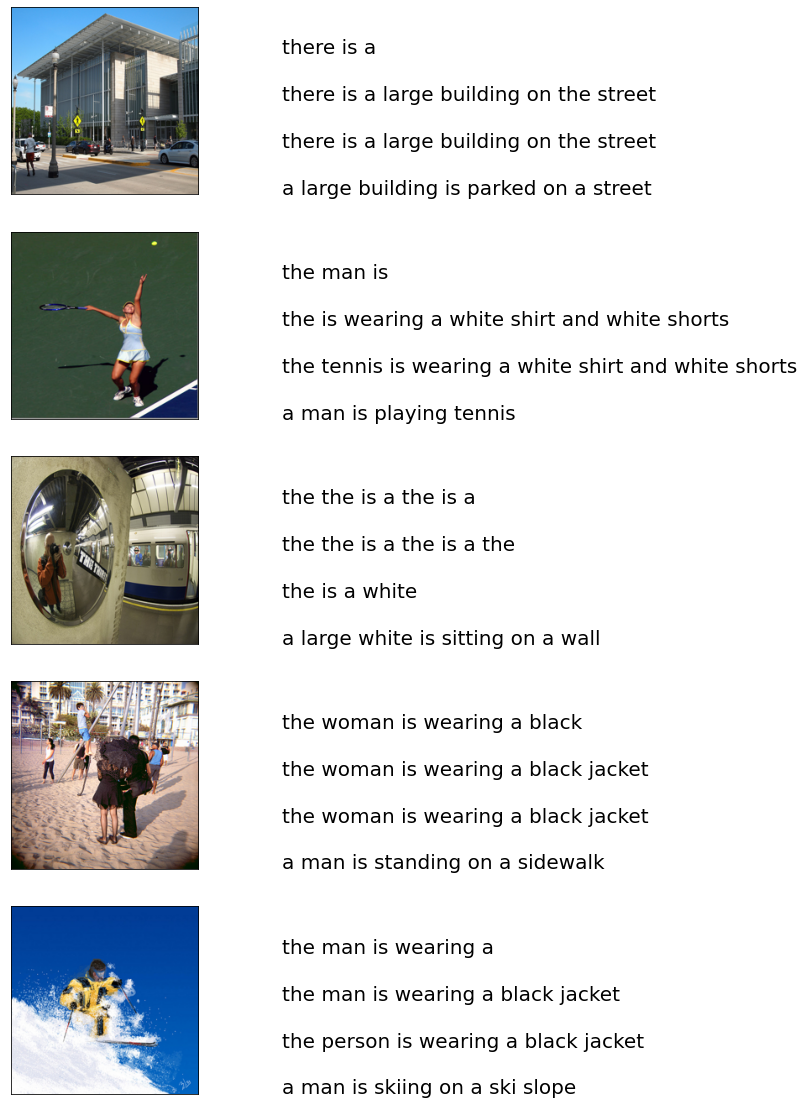

In [41]:
num = 5
count = 1

fig = plt.figure(figsize=(10,20))
for name in test_images[0:5]:
   img = Image.open(image_path+str(name)+'.jpg').convert("RGB").resize((224,224))
   image =  transform_test(img).unsqueeze(0).to(device)
   features = encoder(image)
   output, atten_weights = decoder.greedy_search(features,max_sentence = 30)    
   paragraph = clean_sentence(output)
   ax = fig.add_subplot(num,2,count,xticks=[],yticks=[])
   ax.imshow(img)
   count += 1

   captions = paragraph.split('.')
   captions = [caption.strip() for caption in captions if len(caption)>1]

   ax = fig.add_subplot(num,2,count)
   plt.axis('off')
   ax.plot()
   ax.set_xlim(0,1)
   ax.set_ylim(0,len(captions))
   for i, caption in enumerate(captions):
     ax.text(0,i,caption,fontsize=20)
   count += 1
plt.show()

In [ ]:
img = Image.open('../input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images/2414610.jpg').convert("RGB")
image =  transform_test(img).unsqueeze(0).to(device)

In [ ]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
print(image.shape)
features = encoder(image)

# Pass the embedded image features through the model to get a predicted caption.
output, atten_weights = decoder.greedy_search(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in vocabulary.itos for x in output]), "Each entry in the output needs to correspond to an integer that indicates a the words in vocabulary"

**Visualizing Attention**

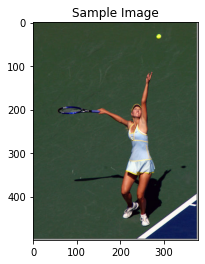

a man is playing tennis . the tennis is wearing a white shirt and white shorts . the man is wearing a white shirt and white shorts . the man


In [43]:
image = Image.open('../input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images/2414610.jpg').convert("RGB")
get_prediction(image)

In [45]:
# function for plot attention in the image sample
def visualize_attention(image, words, atten_weights):
    fig = plt.figure(figsize=(14,12)) 
    len_tokens = len(words)
    
    for i in range(len(words)):
        atten_current = atten_weights[i].detach().cpu().numpy()
        atten_current = atten_current.reshape(7,7)       
        ax = fig.add_subplot(len_tokens//3, len_tokens//3, i+1)
        ax.set_title(words[i])
        img = ax.imshow(np.squeeze(image))
        ax.imshow(atten_current, cmap='gray', alpha=0.8, extent=img.get_extent(), interpolation = 'bicubic')
    plt.tight_layout()
    plt.show()

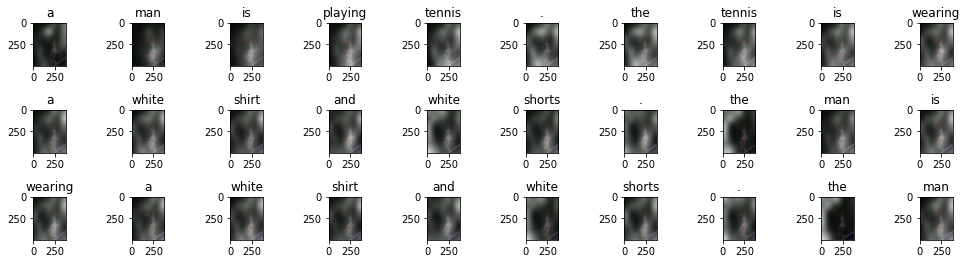

In [47]:
img = Image.open('../input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images/2414610.jpg').convert("RGB")
image =  transform_test(img).unsqueeze(0).to(device)
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image)

# Pass the embedded image features through the model to get a predicted caption.
output, atten_weights = decoder.greedy_search(features)

vocab = vocabulary.itos
words = [vocab.get(idx) for idx in output]
words = [word for word in words if word not in ('<start>','<end>')]


visualize_attention(img, words, atten_weights)